# Proton Radiography: Synthetic Radiographs with Custom Source Profiles

An experimental reality of charged particle radiography experiments is that the source of the particles has finite size and often does not generate a perfectly uniform distribution of particles in velocity space. For this reason, the`plasmapy.diagnostics.proton_radiography.SyntheticProtonRadiograph` particle tracing algorithm allows users to specify their own initial particle positions and velocities. This example will demonstrate how to use this functionality to create a (more) realistic synthetic radiograph.

In [47]:
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from plasmapy.diagnostics import proton_radiography as prad
from plasmapy.plasma.grids import CartesianGrid
from plasmapy.particles import Particle

## Creating Particles

In this example we will create a distribution of 1e5 protons with a 5% variance in energy, a non-uniform angular velocity distribution, and with a finite source extent.

In [48]:
nparticles = 1e5
particle = Particle('p+')

### Creating the Initial Velocity Distribution

First we will create the velocity distribution by generating $\theta$ and $\phi$ angles for each particle. Generating $\phi$ is simple: we will choose the azimuthal angles to just be uniformly distributed

In [49]:
phi = np.random.uniform(high=2 * np.pi, size=int(nparticles))

However, since the solid angle $d\Omega = sin \theta d\theta d\phi$, if we do the same thing for $\theta$ we will end up creating a non-uniform distribution of particles in solid angle.

(709.8021376684695, 100000.0)

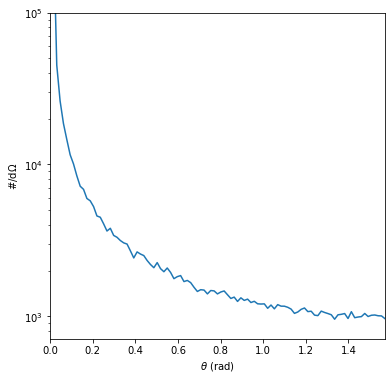

In [50]:
theta = np.random.uniform(high= np.pi/2, size=int(nparticles))

fig, ax = plt.subplots(figsize=(6,6))
theta_per_sa, bins = np.histogram(theta, bins=100 , weights=1/np.sin(theta))
ax.set_xlabel("$\\theta$ (rad)")
ax.set_ylabel("#/d$\\Omega$")
ax.plot(bins[1:], theta_per_sa)
ax.set_yscale('log')
ax.set_xlim(0, np.pi/2)
ax.set_ylim(None, 1e5)

To create a uniform distribution in solid angle, we need to draw values of $\theta$ with a probability distribution weighted by $\sin \theta$. We'll do this using the `np.random.choice` function, which draws `size` elements from a distribution `arg` with a probability distribution `prob`. Setting the `replace` keyword allows the same arguments to be drawn multiple times.

(1376.5375750847109, 100000.0)

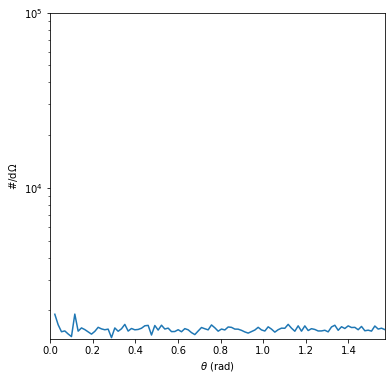

In [51]:
arg = np.linspace(0, np.pi/2, num=int(1e5))
prob = np.sin(arg)
prob *= 1 / np.sum(prob)
theta = np.random.choice(arg, size=int(nparticles), replace=True, p=prob)

fig, ax = plt.subplots(figsize=(6,6))
theta_per_sa, bins = np.histogram(theta, bins=100 , weights=1/np.sin(theta))
ax.plot(bins[1:], theta_per_sa)
ax.set_xlabel("$\\theta$ (rad)")
ax.set_ylabel("#/d$\\Omega$")
ax.set_yscale('log')
ax.set_xlim(0, np.pi/2)
ax.set_ylim(None, 1e5)


Now that we have a uniform distribution, we can perturb it by adding additional factors to the probability distribution used in `np.random.choice`. For this case, let's create a Gaussian distribution in solid angle.

Since particles moving at large angles will not be seen on the radiograph, we will set a bound $\theta_{max}$ on the arguments here. This is equivalent to setting the `max_theta` keyword in `create_particles`.

(1.7677165765764997, 100000.0)

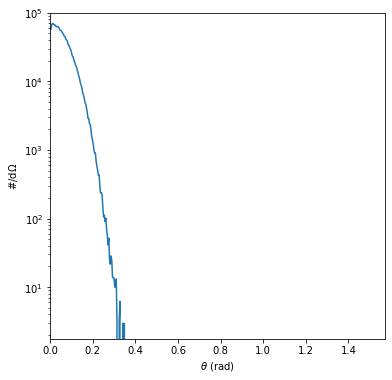

In [52]:
arg = np.linspace(0, np.pi/8, num=int(1e5))
prob = np.sin(arg) * np.exp(-arg**2/0.1**2)
prob *= 1 / np.sum(prob)
theta = np.random.choice(arg, size=int(nparticles), replace=True, p=prob)

fig, ax = plt.subplots(figsize=(6,6))
theta_per_sa, bins = np.histogram(theta, bins=100 , weights=1/np.sin(theta))
ax.plot(bins[1:], theta_per_sa)
ax.set_xlabel("$\\theta$ (rad)")
ax.set_ylabel("#/d$\\Omega$")
ax.set_yscale('log')
ax.set_xlim(0, np.pi/2)
ax.set_ylim(None, 1e5)

Now we will create a Gaussian distribution of speeds with ~5% variance centered on a particle energy of 15 MeV.

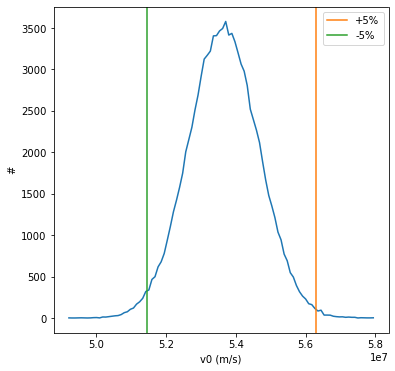

In [53]:
v_cent = np.sqrt(2*15*u.MeV/particle.mass).to(u.m/u.s).value
v0 = np.random.normal(loc=v_cent, scale=1e6, size=int(nparticles))
v0 *= u.m / u.s

fig, ax = plt.subplots(figsize=(6,6))
v_per_bin, bins = np.histogram(v0.si.value, bins=100)
ax.plot(bins[1:], v_per_bin)
ax.set_xlabel("v0 (m/s)")
ax.set_ylabel("#")
ax.axvline(x=1.05*v_cent, label='+5%', color='C1')
ax.axvline(x=0.96*v_cent, label='-5%', color='C2')
ax.legend()

Finally, we will construct velocity vectors centered around the z-axis for each particle.

In [54]:
vel = np.zeros([int(nparticles), 3]) * u.m / u.s
vel[:, 0] = v0 * np.sin(theta) * np.cos(phi)
vel[:, 1] = v0 * np.sin(theta) * np.sin(phi)
vel[:, 2] = v0 * np.cos(theta)

If you want a velocity distribution centered on another vector, the function `proton_radiography._rot_a_to_b` can create an appropriate rotation matrix.

### Creating the Initial Position Distribution

We will begin by defining define a source location for the synthetic radiograph.

In [55]:
source = (0 * u.mm, 0 * u.mm, -10 * u.mm)

We will create an initial position distribution representing a laser spot. The distribution will be cylindrical (oriented along the $z$-axis) with a uniform distribution in z and a Gaussian distribution in radius. We therefore need to create distributions in $z$, $\theta$ and $r$

Just as in the previous section we had to weigth the $\theta$ distribution with a $sin \theta$ probability distribution to end up with a uniform distribution in space, in this case we need to weight the $r$ distribution with a $r$ probability distribution so that particles are uniformly distributed over the disk's area.

Text(0, 0.5, 'z - $z_0$ ($\\mu m$)')

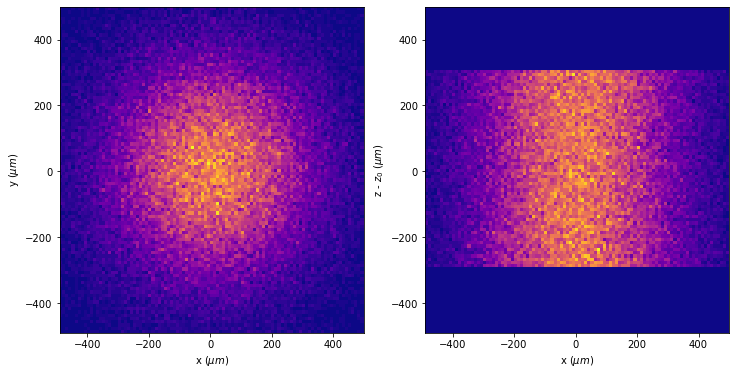

In [56]:
dz = 300 * u.um
z = np.random.uniform(low = (source[2] - dz).to(u.m).value,
                      high = (source[2] + dz).to(u.m).value,
                      size = int(nparticles)
                     )

arg = np.linspace(1e-9, 1e-3, num=int(1e5))
prob = arg * np.exp(-(arg**2/3e-4**2))
prob *= 1 / np.sum(prob)
r = np.random.choice(arg, size=int(nparticles), replace=True, p=prob)


theta = np.random.uniform(low=0, high=2*np.pi, size=int(nparticles))

x = r * np.cos(theta)
y = r * np.sin(theta)

hist, xpos, ypos = np.histogram2d(x*1e6, y*1e6, bins=[100,100], 
                                  range=np.array([[-5e2, 5e2],[-5e2, 5e2]]))

hist2, xpos2, zpos = np.histogram2d(x*1e6, 
                                    (z-source[2].to(u.m).value)*1e6, 
                                    bins=[100,100], 
                                    range=np.array([[-5e2, 5e2],[-5e2, 5e2]]))

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].pcolormesh(xpos[1:], ypos[1:], hist.T, cmap='plasma')
ax[0].set_xlabel("x ($\\mu m$)")
ax[0].set_ylabel("y ($\\mu m$)")

ax[1].pcolormesh(xpos2[1:], zpos[1:], hist2.T, cmap='plasma')
ax[1].set_xlabel("x ($\\mu m$)")
ax[1].set_ylabel("z - $z_0$ ($\\mu m$)")

Finally we will create an array of positions with units

In [57]:
pos = np.zeros([int(nparticles), 3]) * u.m
pos[:, 0] = x * u.m
pos[:, 1] = y * u.m
pos[:, 2] = z * u.m

## Creating a Synthetic Radiograph

To create a synthetic radiograph, we will first create an example field grid representing the analytical electric field produced by a sphere of Gaussian potential.

Text(0.5, 0.92, 'Gaussian Potential Electric Field')

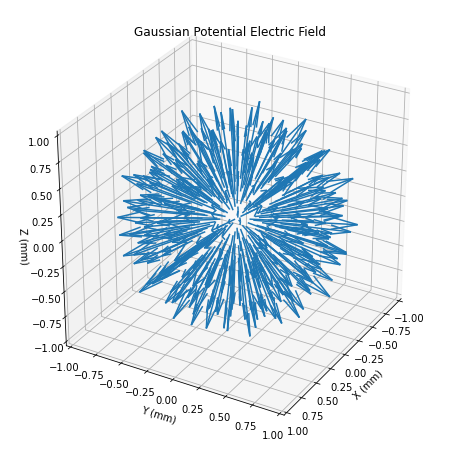

In [58]:
# Create a Cartesian grid
L = 1 * u.mm
grid = CartesianGrid(-L, L, num=100)

# Create a spherical potential with a Gaussian radial distribution
radius = np.linalg.norm(grid.grid, axis=3)
arg = (radius / (L / 3)).to(u.dimensionless_unscaled)
potential = 6e5 * np.exp(-(arg ** 2)) * u.V

# Calculate E from the potential
Ex, Ey, Ez = np.gradient(potential, grid.dax0, grid.dax1, grid.dax2)
Ex = -np.where(radius < L / 2, Ex, 0)
Ey = -np.where(radius < L / 2, Ey, 0)
Ez = -np.where(radius < L / 2, Ez, 0)

# Add those quantities to the grid
grid.add_quantities(E_x=Ex, E_y=Ey, E_z=Ez, phi=potential)


# Plot the E-field
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 30)

# skip some points to make the vector plot intelligable
s = tuple([slice(None, None, 6)] * 3)

ax.quiver(
    grid.pts0[s].to(u.mm).value,
    grid.pts1[s].to(u.mm).value,
    grid.pts2[s].to(u.mm).value,
    grid["E_x"][s],
    grid["E_y"][s],
    grid["E_z"][s],
    length=5e-7,
)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_title("Gaussian Potential Electric Field")

We will then begin to create the synthetic radiograph by specifying the problem geometry.

In [59]:
detector = (0 * u.mm, 0 * u.mm, 100 * u.mm)
sim = prad.SyntheticProtonRadiograph(grid, source, detector, verbose=True)

Source: [ 0.    0.   -0.01] m
Detector: [0.  0.  0.1] m
Magnification: 11.0


c:\users\peter\documents\github\plasmapy\plasmapy\plasma\grids.py:157: RuntimeWarning: B_x is not specified for the provided grid.This quantity will be assumed to be zero.
  RuntimeWarning,
c:\users\peter\documents\github\plasmapy\plasmapy\plasma\grids.py:157: RuntimeWarning: B_y is not specified for the provided grid.This quantity will be assumed to be zero.
  RuntimeWarning,
c:\users\peter\documents\github\plasmapy\plasmapy\plasma\grids.py:157: RuntimeWarning: B_z is not specified for the provided grid.This quantity will be assumed to be zero.
  RuntimeWarning,


Again we will use the `load_particles` function to add the particles we have created above.

In [60]:
sim.load_particles(pos, vel, particle=particle)

Now, instead of using `create_particles` to create the particle distribution, we will use the `load_particles` function to add the particles we have created above.

After this point, the rest of the process for creating the radiograph is unchanged.

Particles on grid:   0%|          8.5e+01/9.1e+04 particles
Run completed
Fraction of particles tracked: 91.2%
Fraction of tracked particles that entered the grid: 81.3%
Fraction of tracked particles deflected away from the detector plane: 0.0%


Text(0.5, 1.0, 'Synthetic Proton Radiograph')

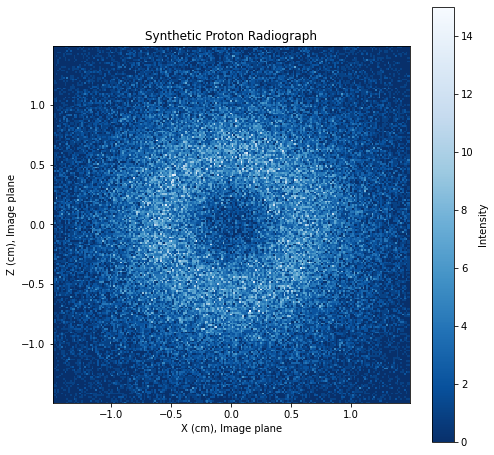

In [61]:
sim.run()

size = np.array([[-1, 1], [-1, 1]]) * 1.5 * u.cm
bins = [200, 200]

hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins)

fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(
    hax.to(u.cm).value, vax.to(u.cm).value, intensity.T, cmap="Blues_r",
)
cb = fig.colorbar(plot)
cb.ax.set_ylabel("Intensity")
ax.set_aspect("equal")
ax.set_xlabel("X (cm), Image plane")
ax.set_ylabel("Z (cm), Image plane")
ax.set_title("Synthetic Proton Radiograph")

Calling the `synthetic_radiograph` function with the `ignore_grid` keyword set will display the source profile (the radiograph calculated in the absence of any grid fields).

Text(0.5, 1.0, 'Source Profile')

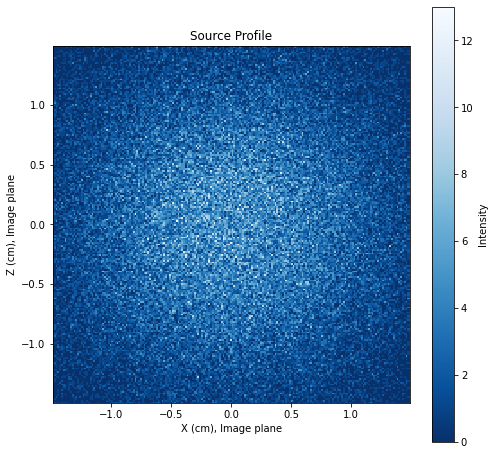

In [62]:
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins, ignore_grid=True)

fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(
    hax.to(u.cm).value, vax.to(u.cm).value, intensity.T, cmap="Blues_r",
)
cb = fig.colorbar(plot)
cb.ax.set_ylabel("Intensity")
ax.set_aspect("equal")
ax.set_xlabel("X (cm), Image plane")
ax.set_ylabel("Z (cm), Image plane")
ax.set_title("Source Profile")

Text(0.5, 1.0, 'Mean source profile')

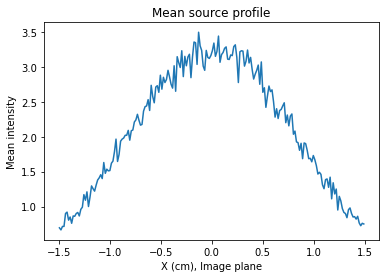

In [63]:
fig, ax = plt.subplots()
ax.plot(hax.to(u.cm).value, np.mean(intensity, axis=0))
ax.set_xlabel("X (cm), Image plane")
ax.set_ylabel("Mean intensity")
ax.set_title("Mean source profile")